In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import math
import copy

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.edgeworth_development import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## General parameters

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
mock_catalog.weights = mock_catalog.weights
nbar = np.sum(mock_catalog.weights)/mock_catalog.boxsize**3
nmesh = 1024

In [4]:
nbar

0.014671661464273195

In [5]:
mock_catalog.size/mock_catalog.boxsize**3

0.01466455875

### Catalog with random particles with independant gaussian weights

In [6]:
#from mockfactory import RandomBoxCatalog
#boxsize = mock_catalog.boxsize
#boxcenter = mock_catalog.boxcenter
#data = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=0)
#data['Weight'] = 1 + np.random.normal(loc=0.0, scale=sigma, size=data['Position'].shape[0])
#offset = boxcenter - boxsize/2.
#positions = copy.deepcopy((data['Position'] - offset) % boxsize + offset)
#weights = copy.deepcopy(data['Weight'])
#mock_catalog = catalog_data.Data(positions.T, z, boxsize, boxcenter, name='test', weights=weights)
#nbar = float(np.sum(mock_catalog.weights)/mock_catalog.boxsize**3)

In [7]:
cellsize = 10
resampler = 'tsc'

mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000022.24]  12-05 15:01  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 117316470.
[000024.14]  12-05 15:01  CatalogMesh                  INFO     Painted 4194304 out of 117316470 objects to mesh.
[000024.14]  12-05 15:01  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 117316470.
[000025.98]  12-05 15:01  CatalogMesh                  INFO     Painted 8388608 out of 117316470 objects to mesh.
[000025.98]  12-05 15:01  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 117316470.
[000027.83]  12-05 15:01  CatalogMesh                  INFO     Painted 12582912 out of 117316470 objects to mesh.
[000027.83]  12-05 15:01  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 117316470.
[000029.66]  12-05 15:01  CatalogMesh                  INFO     Painted 16777216 out of 117316470 objects to mesh.
[000029.66]  12-05 15:01  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 117316470.
[000031.50]  12-05 15:02  CatalogMesh      

## Split model

In [8]:
kN = np.pi*nmesh/mock_catalog.boxsize
kN

1.6084954386379742

In [9]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [10]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [11]:
shot_noise = 0
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, pk=pkdamped, bias=1.8, nsplits=1, shot_noise=shot_noise, nbar=nbar)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/1.0.0/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


## Shot noise cumulants

In [12]:
## Generate random particles and readout density at each particle
rng = np.random.RandomState(seed=0)
positions = [o + rng.uniform(0., 1., mock_density.data.size)*b for o, b in zip((mock_density.offset,)*3, (mock_density.boxsize,)*3)]
shifted_positions = np.array(positions) - mock_density.offset
densities = mock_density.density_mesh.readout(shifted_positions.T, resampler=resampler)

In [13]:
p = 4
#shotnoise_cumulants = [model.smoothed_shot_noise_cumulant(i+1)/nbar**(i+1) * np.mean(mock_density.data.weights**(i+1)) for i in range(p)]
#shotnoise_cumulants = [model.smoothed_density_cumulant(i+1) for i in range(p)]
shotnoise_cumulants = [1., 0.380896125546061, 0.05031402, 0.04889487]
shotnoise_cumulants[0] -= 1
print(shotnoise_cumulants)

gaussian_cumulants = [0 for i in range(p)]
gaussian_cumulants[1] = model.sigma_RR[0]**2
print(gaussian_cumulants)

cumulants = np.array(shotnoise_cumulants) # + np.array(gaussian_cumulants)
print(cumulants)

trunc_cumulants = np.array(shotnoise_cumulants[0:2]) #+ np.array(gaussian_cumulants[0:2])

[0.0, 0.380896125546061, 0.05031402, 0.04889487]
[0, 0.25782308018865785, 0, 0]
[0.         0.38089613 0.05031402 0.04889487]


In [14]:
gauss_shotnoise = ExpandedNormal(cum=trunc_cumulants.tolist())
edgew = ExpandedNormal(cum=cumulants.tolist())
gauss = ExpandedNormal(cum=gaussian_cumulants)
#shotnoise = ExpandedNormal(cum=shotnoise_cumulants)
print(shotnoise_cumulants)
#trunc_shotnoise = ExpandedNormal(cum=shotnoise_cumulants[0:2])
x = np.linspace(-2, 2, 100)

[0.0, 0.380896125546061, 0.05031402, 0.04889487]


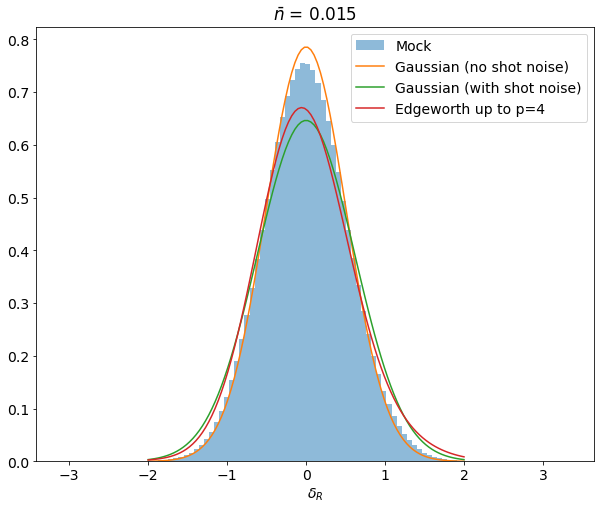

In [16]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

plt.hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label = r'Mock')
plt.plot(x, gauss.pdf(x), label='Gaussian (no shot noise)')
#plt.plot(x, shotnoise.pdf(x), label='Shot noise')
#plt.plot(x, trunc_shotnoise.pdf(x), label='Gaussian shot noise')
plt.plot(x, gauss_shotnoise.pdf(x), label='Gaussian (with shot noise)')
plt.plot(x, edgew.pdf(x), label='Edgeworth up to p={}'.format(p))
plt.xlabel(r'$\delta_R$')
plt.legend()
plt.title(r'$\bar{{n}}$ = {:.3f}'.format(nbar))
plt.show()

In [18]:
delta = np.linspace(-4, 4, 1000)
model.density_with_shot_noise(delta, p=4)

array([6.45496724e-13, 7.09981655e-13, 7.80763760e-13, 8.58443218e-13,
       9.43675935e-13, 1.03717858e-12, 1.13973403e-12, 1.25219738e-12,
       1.37550233e-12, 1.51066826e-12, 1.65880787e-12, 1.82113545e-12,
       1.99897589e-12, 2.19377451e-12, 2.40710759e-12, 2.64069401e-12,
       2.89640765e-12, 3.17629106e-12, 3.48257009e-12, 3.81766993e-12,
       4.18423239e-12, 4.58513463e-12, 5.02350954e-12, 5.50276777e-12,
       6.02662156e-12, 6.59911059e-12, 7.22463001e-12, 7.90796068e-12,
       8.65430198e-12, 9.46930730e-12, 1.03591224e-11, 1.13304269e-11,
       1.23904793e-11, 1.35471652e-11, 1.48090502e-11, 1.61854361e-11,
       1.76864224e-11, 1.93229724e-11, 2.11069847e-11, 2.30513699e-11,
       2.51701345e-11, 2.74784701e-11, 2.99928504e-11, 3.27311359e-11,
       3.57126867e-11, 3.89584835e-11, 4.24912590e-11, 4.63356390e-11,
       5.05182943e-11, 5.50681046e-11, 6.00163347e-11, 6.53968249e-11,
       7.12461947e-11, 7.76040635e-11, 8.45132868e-11, 9.20202108e-11,
      

In [20]:
# Get theoretical quantiles
import scipy.stats

density_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [17]:
density_bins

array([       -inf, -0.21870731,  0.21870731,         inf])

In [21]:
model.ccf_randoms_tracers(density_bins=density_bins, shot_noise=True, p=4)

array([[[-7.57440001e-01],
        [-7.44092035e-01],
        [-7.31042954e-01],
        [-7.12915715e-01],
        [-6.87598631e-01],
        [-6.50523298e-01],
        [-6.28691130e-01],
        [-5.96461415e-01],
        [-5.48536889e-01],
        [-4.98902008e-01],
        [-4.68027444e-01],
        [-4.29710456e-01],
        [-3.91867889e-01],
        [-3.52650578e-01],
        [-3.22350379e-01],
        [-2.88803519e-01],
        [-2.59189500e-01],
        [-2.34249484e-01],
        [-2.11093278e-01],
        [-1.88592082e-01],
        [-1.71141568e-01],
        [-1.53023013e-01],
        [-1.37999879e-01],
        [-1.24454590e-01],
        [-1.13425706e-01],
        [-1.03123344e-01],
        [-9.36290149e-02],
        [-8.49510719e-02],
        [-7.81070457e-02],
        [-7.10299994e-02],
        [-6.47881286e-02],
        [-5.94246149e-02],
        [-5.48567328e-02],
        [-5.02557867e-02],
        [-4.62767712e-02],
        [-4.27413830e-02],
        [-3.95696581e-02],
 

In [18]:
test = model.compute_delta_tilde(density_bins)
test

array([[-5.53867340e-01],
       [-6.74687162e-17],
       [ 5.53867340e-01]])

In [21]:
test = model.compute_delta_tilde(density_bins, shot_noise=True)
test

0.9999999999999893
[1.38089613]
[2.1930024]
[3.97077329]


array([-0.44569488,  0.04592957,  1.11057186])